# Stylized fact
Stylized facts refer to those common stastical properties derived from different source of data.
They are particularly valuable in the study of financial markets, since they serve as criteria for constructing models. Also, they can be utilized to design strategy.

Today we want to introduce the stylized facts of Uniswap pools, CEX and compare them with the traditional finance data, including empirical distribution, autocorrelation, TRA, leverage effect. We also want to study the interaction between pools and CEX.

## 0.Preparation

In [1]:
import pandas as pd
import json
import os 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import df2img
from datetime import datetime , timedelta
import scipy as sci
import statsmodels.formula.api as smf
import statsmodels.api as st
import matplotlib as mpl
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
start_time = '2021-09-23 10:40:00'
end_time = '2023-10-18 16:10:00'

In [3]:
def df_setting(df,T,label,token_0,token_1,timeframe_align):

    df['return'] = df['close'].apply(np.log).diff()
    df['dT'] = T
    df['token'] = f'{token_0} & {token_1}' 
    if timeframe_align == True:
        df = df[(df.index>=start_time)&(df.index<=end_time)].copy()
    else:
        label+= ' all'
    df['label'] =label
    return df

In [4]:
#read pool data

token_0 = 'WETH'
token_1_list =['USDC','USDT','DAI']
time_list = ['10min','1H']
label_dic = {'arb_3000':'arb_3000','arb_500':'arb_500','m_3000':'mainnet_3000','m_500':'mainnet_500'}
df_list =[]
for key , value in label_dic.items():
    for token_1 in token_1_list:
        for T in time_list:
            try:
                df=  pd.read_csv(f'Data/organized data/{token_0}_{token_1}_{value}/{token_0}_{token_1}_{key}_{T}.csv' 
                                 , index_col = 'datetime')[['close']] 
                df.index = pd.to_datetime(df.index)
                df = df_setting(df,T,key,token_0,token_1,timeframe_align=True)
                df_list.append(df)
            except FileNotFoundError:
                print(f'no {key} {token_0} & {token_1} {T}')
                continue


no arb_3000 WETH & USDT 10min
no arb_3000 WETH & USDT 1H
no arb_500 WETH & DAI 10min
no arb_500 WETH & DAI 1H
no m_500 WETH & USDT 10min
no m_500 WETH & USDT 1H
no m_500 WETH & DAI 10min
no m_500 WETH & DAI 1H


In [5]:
#read Binance data
#ETH,BTC
token_1 = 'USD'
label = 'Binance'
for token_0 in ['ETH' , 'BTC']:
    for T in time_list:
        try:
            df=  pd.read_csv(f'Data/Binance/{token_0}/{token_0}_{token_1}_{T}.csv' , index_col = 'datetime') 
            df.index = pd.to_datetime(df.index)
            df1 = df_setting(df,T,label,token_0,token_1,timeframe_align=True)
            df_list.append(df1)

            if token_0 == 'ETH':
                df2 = df_setting(df,T,label,token_0,token_1,timeframe_align=False)
                df_list.append(df2)
            
        except FileNotFoundError:
            print(f'no {label} {token_0} & {token_1} {T}')

            continue


In [6]:
# read SPY , EUR data
df_list_trad =[]
def spy_eur(s):
    if s=='SPY':
        return 'SPY & USD'
    elif s == 'EUR':
        return 'EUR & USD'
    
df_trad =pd.read_csv('Data/SPY_EUR_over60min.csv',index_col='datetime')
df_trad.index = pd.to_datetime(df_trad.index)
df_trad.drop(columns='Unnamed: 0',axis=1,inplace = True)
df_trad['dT']='1H'
df_trad['token']=df_trad.apply(lambda r: spy_eur(r.label) ,axis=1)

df_trad_partial =df_trad[(df_trad.index>= start_time)&(df_trad.index<=end_time)].copy()
df_trad['label']= df_trad.apply(lambda r: r.label+' all' ,axis=1)

#note that each dataframe contains both EUR and SPY!!
df_list_trad.append(df_trad_partial[['close','return','dT','label','token']])
df_list_trad.append(df_trad[['close','return','dT','label','token']])

In [7]:
tempt = []
# sparate EUR and SPY
for df in df_list_trad:
    lab_array = df.label.unique()
    for lab in lab_array:
        tempt.append(df[df.label==lab])
df_list_trad = tempt

In [8]:
#put all together
df_all = pd.concat(df_list+df_list_trad)
#df_all_trad = pd.concat(df_list_trad)

### other CEX tokens

In [25]:
#read coinbase data

#ETH,BTC
typ = 'L1'
path = f'Data/coinbase/{typ}'

df_list_L1 = []
for token_0 in [name for name in os.listdir(path)]:
    df=  pd.read_csv(f'Data/coinbase/{typ}/{token_0}' , index_col = 'datetime')
    
    print(df.token[0])
    df.index = pd.to_datetime(df.index)
    df['return'] = np.log(df['close']) - np.log(df['close'].shift(1))
    df['dT'] = '1H'
    df = df[['close','return','dT','label','token'] ]
    # df = df[(df.index>=start_time)&(df.index<=end_time)]
    df_list_L1.append(df)
df_all_L1 = pd.concat(df_list_L1)

ADA & USD
ALGO & USD
ATOM & USD
AVAX & USD
BCH & USD
BTC & USD
DOT & USD
ETH & USD
GNO & USD
LTC & USD
SOL & USD
XRP & USD


In [26]:
df_list_mix = []

for s in ['L2','Oracle','Gaming','Shitcoin','Stable']:
    typ = s
    path = f'Data/coinbase/{typ}'

    for token_0 in [name for name in os.listdir(path)]:
        df=  pd.read_csv(f'Data/coinbase/{typ}/{token_0}' , index_col = 'datetime')
        token = df.token[0]
        if token in ['DAI & USD' ,'USDT & USD']:
            continue
        print(token)
        df.index = pd.to_datetime(df.index)
        df['return'] = np.log(df['close']) - np.log(df['close'].shift(1))
        df['dT'] = '1H'
        df = df[['close','return','dT','label','token'] ]
        if token == 'SHIB & USD':
            df = df[(df.index>='2022')]
        df_list_mix.append(df)
# also compare them with ETH
df_list_mix.append(df_all_L1[df_all_L1.token=='ETH & USD'].copy())
df_all_mix = pd.concat(df_list_mix)

MATIC & USD
OP & USD
LINK & USD
AXS & USD
SAND & USD
DOGE & USD
SHIB & USD


In [27]:
df_list_defi = []

for s in ['DeFi']:
    typ = s
    path = f'Data/coinbase/{typ}'

    for token_0 in [name for name in os.listdir(path)]:
        df=  pd.read_csv(f'Data/coinbase/{typ}/{token_0}' , index_col = 'datetime')
    
        print(df.token[0])
        df.index = pd.to_datetime(df.index)
        df['return'] = np.log(df['close']) - np.log(df['close'].shift(1))
        df['dT'] = '1H'
        df = df[['close','return','dT','label','token'] ]
        # df = df[(df.index>=start_time)&(df.index<=end_time)]
        df_list_defi.append(df)
# also compare them with ETH
df_list_defi.append(df_all_L1[df_all_L1.token=='ETH & USD'].copy())
df_all_defi = pd.concat(df_list_defi)

AAVE & USD
BAL & USD
CRV & USD
CVX & USD
INJ & USD
SNX & USD
UNI & USD


### rolling for pdf

In [24]:
df_list_rolling_trad = [ ]
for df in df_list_trad:
    labs =  df[~df.label.duplicated(keep='last')].label.values
    for lab in labs:
        dff = df[df.label==lab]
        df_list_rolling_trad.append(dff)
        for dT in ['1D','1W','1M']:
            df_list_rolling_trad.append(resample_by_rolling(dff,dT))
df_rolling = pd.read_csv('Data/organized data/rollingwindow_pool_CEX.csv')
df_rolling.rename(columns={'Unnamed: 0':'datetime'},inplace=True)
df_rolling.set_index('datetime',inplace = True)
df_rolling.index = pd.to_datetime(df_rolling.index)
df_list_rolling =[]
label_array = df_rolling['label'].unique()
token_array =  df_rolling['token'].unique()
time_list = ['10min', '1H' , '1D','1W','1M']
for lab in label_array:
    for token in token_array:
        for dT in time_list:
            df = df_rolling[(df_rolling.label==lab)&(df_rolling.token == token)& (df_rolling.dT == dT)  ]
            if len(df)==0:
                continue
            df_list_rolling.append(df)
temp = df_list_rolling + df_list_rolling_trad

### Tools

In [9]:
def std_array(array):
    std_list=[]
    N = len(array)
    var = np.var(array)
    m = np.mean(array)
    for x in array:
        var_new = (N*var - x**2)/(N-1) - (N+1)/(N-1) * m**2 + 2*m*x/(N-1)
        std_list.append( np.sqrt(var_new) )
    return np.array(std_list)
# use usal std
def normalize(array):
    return (array - np.mean(array) )/ np.std(array)
#std_array(array)

In [10]:
def plot_pdf(array,norm=True):
    if norm == True:
        array = normalize(array)
    if len(array) < 10000:
        n = 11
        m = 6
    else:
        n = 21
        m = 11
    l = -5
    r = 5
    bin_m = np.linspace(-2,2,60)
    
    bin_l = np.linspace(l,-2,n)
    bin_r = np.linspace(2,r,n)
    bin_l = bin_l[bin_l !=-2]
    bin_r = bin_r[bin_r != 2]
    
    r_max=max(array)
    r_min=min(array)
    if r_max > r:
        bin_rr = np.linspace(r,max(array),m)
        bin_rr = bin_rr[bin_rr != r]
    else:
        bin_rr=[]
    if r_min < l:
        bin_ll = np.linspace(min(array),l,m)
        bin_ll = bin_ll[bin_ll !=l]
    else:
        bin_ll=[]
     
    bins = np.concatenate((bin_ll,bin_l,bin_m,bin_r,bin_rr ))
    
    return np.histogram( array  ,bins=bins,density=True );

In [11]:
def cdf_df(array,norm = True):
    if norm == True:
        array = normalize(array)
    value = np.sort(array)
    cdf = np.arange(1, len(array)+1) / (len(array))
    df = pd.DataFrame({'x': value, 'y': cdf}) 
    
    return df.drop_duplicates(['x'],keep='last') #if some value is repeated in data_array, keep last



In [12]:
def cdf_modify(x,y,shift):
    if x>=0:
        if y ==1:
            return -100
        else:
            return np.log(1-y)
    if x <0:
        return np.log(y) +shift
    
        
def shiftlogcdf_df(array):
    df = cdf_df(array,norm=False)

    y_r = df[df.x>=0].values[0,1]
    y_l= df[df.x < 0].values[-1,1]
    shift = np.log(1-y_r) -np.log( y_l)
    df.y =df.apply( lambda r: cdf_modify(r.x,r.y,shift) ,axis=1)

    return df


Generate larger time scale data: rolling window and rolling sum. Note that in the results, the return at time $t$ is
the return between $t$ and $t+T$.

In [13]:
def rolling_window(df,dT):
    if dT =='1D':
        offset_increm = pd.DateOffset(days=1)
    elif dT == '1W':
         offset_increm = pd.DateOffset(weeks=1)
    elif dT == '1M':
         offset_increm = pd.DateOffset(months=1)
    time = df.index[0]
    basic_increm = df.index[1] - time
    time_list =[]
    price_list =[]
    return_list =[]
    scale_array = std_array(df['return'].values)
    while time + offset_increm <= df.index[-1]:
        close =df.xs(time).close
        new_close =df.xs(time +offset_increm).close
        r = np.log(new_close)-np.log(close) 
        return_list.append(r)
        time_list.append(time)
        price_list.append(close)
        time += basic_increm
    dff = pd.DataFrame(data = { 'close': price_list,'return':return_list ,'dT':dT ,
                                'label':df.label[0],'token':df.token[0] },index =time_list )
    
    return dff

In [14]:
def rolling_sum(df,dT):
    if 'scaled return' not in df.columns:
        df['scaled return']= df[['return']].apply(lambda col : col/std_array(col) )

    if dT== '1H':
        offset_increm =pd.to_timedelta('1H')
    elif dT =='1D':
        offset_increm = pd.DateOffset(days=1)
    elif dT == '1W':
        offset_increm = pd.DateOffset(weeks=1)
    elif dT == '1M':
        offset_increm = pd.DateOffset(months=1)
    time = df.index[0]
    basic_increm = df.index[1] - time
    time_list =[]
    price_list =[]
    return_list =[]
    while time + offset_increm <= df.index[-1]:
        close =df.xs(time).close
        time_list.append(time)
        price_list.append(close)
        return_list.append( df.loc[time+basic_increm:time + offset_increm , 'scaled return'].sum() )
        time += basic_increm
    return pd.DataFrame({'close': price_list,'scaled return': return_list, 'dT': dT ,'label': df.label[0],'token':df.token[0] } 
                        , index =time_list)


The results from rolling_window and rolling_sum are almost the same( rolling_window scaled by the std_array of the generating array)

In [15]:

# for 24/7 data
def plot_acf(method_list=['none','abs'],df_all=df_all,time_list=['1H'],nlags=96,scale=False):
    ''' method_list: list of 'none', 'abs', 'square'   '''  
    df = df_all[df_all.dT.isin(time_list)].copy()
    acf_dict = {}
    
    def scale_len(x,scale=False):
        if scale:
            return 1
        else:
            return np.sqrt(len(x))
    for k, method  in enumerate(method_list):
        if method== 'none':
            df_acf = df.groupby(['label','token','dT'])['return'].apply(lambda x :st.tsa.stattools.acf(x[1:],
                                                                            nlags=nlags,fft=False)*scale_len(x[1:]))
        elif method == 'abs':
            df_acf =df.groupby(['label','token','dT'])['return'].apply(lambda x :st.tsa.stattools.acf( np.abs(x[1:]),
                                                                            nlags=nlags,fft=False)*scale_len(x[1:]))
        elif method == 'square':
            df_acf = df.groupby(['label','token','dT'])['return'].apply(lambda x :st.tsa.stattools.acf( x[1:]**2,
                                                                            nlags=10,fft=False)*scale_len(x[1:]))

        df_acf = pd.DataFrame(dict(df_acf)).reset_index()
        df_acf = df_acf.rename(columns={'index':'Lags'})
        df_acf =df_acf.melt(id_vars='Lags',var_name=['label','token','dT'] )
        acf_dict[method] = df_acf
    return acf_dict
 

Autocorrelation function is
$$ 
ACF(k) = \frac{\mathbb{E}[ (X_t - \mu) (X_{t+k} - \mu)]}{\sigma^2}
$$
For non-24/7 data, we estimate it by
$$ 
\frac{  \frac{1}{N}\sum_{t \leq T} (x_t - \hat{\mu}) (x_{t+k} - \hat{\mu} )}{\hat{\sigma}^2}
$$

here $N$ can be: 
* $T$ total length of the data 
* $T-k$ exact total number of such pair if there's no time gap in the data 
* $N_k$ exact total number of such pair 

Define new acf function that divide the product by the square root of the exact length.(adjust the scale w.r.t the error bar) 
Also, estimate mean and std by those pair corresponding to the given lag, rather than the whole return time series.

In [16]:
def cor(a1,a2):
    return ((a1 - a1.mean() )@(a2 - a2.mean() ))/ (a1.std()*a2.std())

def plot_acf_2( dff,nlags=96):
    hour = pd.Timedelta('0 days 01:00:00')
    df = dff.copy()
    T_array = df.index
    df['abs return'] = df['return'].abs()
    df_acf = pd.DataFrame(columns=['Lags','return','shifted return','method'])
    R_product = []
    Lags = []
    R =[]
    absR=[]
    for t in T_array:
        # print the time per quarter
        if (t-df.index[0])/hour % (24*30*4)==0:
            print(t)
        for s in T_array[np.logical_and(T_array>=t ,T_array<= t+ nlags*hour)]:
            diff = (s-t)/hour
            Lags.append( int(diff) )
            R.append( ( df.loc[t,'return'], df.loc[s,'return'] ) )
            absR.append( (df.loc[t,'abs return'], df.loc[s,'abs return'] ) )
    R = np.array(R)   
    absR = np.array(absR)      
    df_acf['Lags'] = Lags + Lags
    df_acf['method'] = ['none' for i in range(len(Lags))] + ['abs' for i in range(len(Lags))]
    df_acf.loc[df_acf.method=='none','return'] = R[:,0] 
    df_acf.loc[df_acf.method=='abs','return'] = absR[:,0] 
    df_acf.loc[df_acf.method=='none','shifted return'] = R[:,1] 
    df_acf.loc[df_acf.method=='abs','shifted return'] = absR[:,1] 
    
    df_acf=df_acf.groupby(['method','Lags']).apply(lambda r: pd.Series(
                      {'value': cor(r['return'],r['shifted return'] )/np.sqrt(len(r)) }) ).reset_index()
    df_acf['label']=df.label[0]
    df_acf['dT']='1H'
    df_acf['token'] = df.token[0]
    return df_acf

In [17]:
def cc(pool_label,pool_token,dT,lag):
    cex_return = df_all[ (df_all.label == 'Binance') &( df_all.token == 'ETH & USD' )& (df_all.dT == dT)]['return'].values
    pool_return = df_all[ (df_all.label == pool_label) &( df_all.token == pool_token )& (df_all.dT == dT)]['return'].values
    return np.arange(lag) , st.tsa.stattools.ccf(pool_return,cex_return ,nlags= lag), st.tsa.stattools.ccf(cex_return,pool_return,nlags= lag)

For SPY & EUR data, we need to use different resampling and rolling methods.

In [18]:
def resample_close(x:pd.DataFrame,rPeriod='1D'):

    y = x[['close','label','dT']].copy()
    y.index=pd.to_datetime(y.index)

    result = y[["close"]].resample(rPeriod).last()
    result['return'] = result[['close']].apply(np.log).diff()
    return result.assign(label =y.label[0], dT=rPeriod,token=x.token[0]).dropna()

def resample_by_rolling(x:pd.DataFrame,rPeriod="1W"):
    result = resample_close(x,rPeriod="1D")
    if rPeriod == '1D':
        pass
    else:
        if rPeriod == "1W": days=5 
        elif rPeriod == "1M": days=22
        elif rPeriod == "1Q": days=65
        result.loc[:,'return'] = np.log(result["close"].shift(-days)) - np.log(result["close"])
       
    return result.assign( dT=f"{rPeriod}").dropna()
    

In [19]:
def time_rev_day(df,dT='1H',days=np.arange(1,22)):
    a =  df[df['dT']==dT].copy()
    a['day'] = a.index.date
    a['rD'] = a.groupby('day')['close'].diff()/a.groupby('day')['close'].shift(1)
    b = pd.DataFrame(a.groupby('day')['rD'].std())
    b['open'] = a.groupby('day')['close'].first().to_numpy()
    b['close'] = a.groupby('day')['close'].last().to_numpy()
    b['R'] = (b['close']-b['open'])/b['open']
    b['S'] = b['rD']-np.mean(b['rD'])
    c_mat = np.zeros([len(days),2])
    for d in days:
        tb = b.copy()
        #tb= b
        tb['h'] = tb['R'].shift(d)
        tb['f'] = tb['R'].shift(-d)
        tb = tb.dropna()
        c_mat[d-1,0] = np.corrcoef(np.abs(tb['h']),tb['rD'])[0,1]
        c_mat[d-1,1] = np.corrcoef(np.abs(tb['f']),tb['rD'])[0,1]
        #c_mat[d-1,0] = np.corrcoef(tb['h']**2,tb['rD']**2)[0,1]
        #c_mat[d-1,1] = np.corrcoef(tb['f']**2,tb['rD']**2)[0,1]
    return c_mat

In [20]:

def leverage(dff,dT='1H',nlag = 10):
    df = dff[dff.dT==dT].copy()
    R = df['return'].values
    absR= np.abs(df['return'])
    y_n = st.tsa.stattools.ccf(R,absR ,nlags= nlag)
    y_p =  st.tsa.stattools.ccf(absR,R,nlags= nlag)
    return np.arange(nlag) , y_p, y_n 
                               

In [21]:
def plot_pdf_misP(array,norm=False):
    if norm == True:
        array = normalize(array)
    if len(array) < 10000:
        n = 11
        m = 6
    else:
        n = 21
        m = 11
    # 99%insdie (l,r)
    l = -0.008
    r = 0.008
    
    # 60% inside (-0.002,0.002)
    bin_m = np.linspace(-0.002,0.002,60)
    
    bin_l = np.linspace(l,-0.002,n)
    bin_r = np.linspace(0.002,r,n)
    bin_l = bin_l[bin_l !=-2]
    bin_r = bin_r[bin_r != 2]
    
    r_max=max(array)
    r_min=min(array)
    if r_max > r:
        bin_rr = np.linspace(r,max(array),m)
        bin_rr = bin_rr[bin_rr != r]
    else:
        bin_rr=[]
    if r_min < l:
        bin_ll = np.linspace(min(array),l,m)
        bin_ll = bin_ll[bin_ll !=l]
    else:
        bin_ll=[]
     
    bins = np.concatenate((bin_ll,bin_l,bin_m,bin_r,bin_rr ))
    
    return np.histogram( array  ,bins=bins,density=True );
def inside_ratio(array,a):
    return len(array[ np.logical_and (array <= a ,array >= -a )]) / len(array)
def eff_range(array,ratio=0.95):
    for a in np.linspace(0,1,10000):
        if a == 0:
            continue
        if inside_ratio(array,a)>= 0.95:
            break
    return a

### Colors

In [22]:
#color setting


colormap = mpl.colormaps.get_cmap('turbo')  
colors = [colormap(i) for i in range(colormap.N)]

hex_colors = [mpl.colors.rgb2hex(color) for color in colors]

In [23]:
color_list = ['#10A37F', '#147960', '#024736', '#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', 
              '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', 
              '#000075', '#808080', '#00008B', '#000000', '#ffd8b1', '#fffac8', '#aaffc3']

In [24]:
prop_cycle = plt.rcParams['axes.prop_cycle']
c_cycle = prop_cycle.by_key()['color']

## 1.Empirical distribution

### pdf
We remove the zeros in return arrays, normalize them
using time-dependent standard deviation 

$$ \sigma_i \equiv \sqrt{\frac{1}{N-1}\sum_{ \{j \leq N \mid  j \neq i \}} (x_j - \mu)^2 }
   = \sqrt{\frac{1}{N-1} (N \sigma^2 - x_i^2) - \frac{N+1}{N-1} \mu^2 + \frac{2 \mu}{N-1} x_i}$$
   
and then plot the histograms. For the bins setting, we use $60$ bins on $[-2,2]$, $2n$ bins $[-5,5] - [-2,2]$ and $n$ bins on $[-5,5]^c$ where
$n = 20$ if length of return array $> 10000$ and $n =10$ else.

#### Pool & CEX & trad fin
Return in short timescale have **fatter tail**, but **converge to standard Gaussian** for long time scale (central limit theorem holds)
We also see the **gain/loss asymmetry**, larger values(abs) in negative(loss) than positive(gain) part, i.e pdf is negative skew.

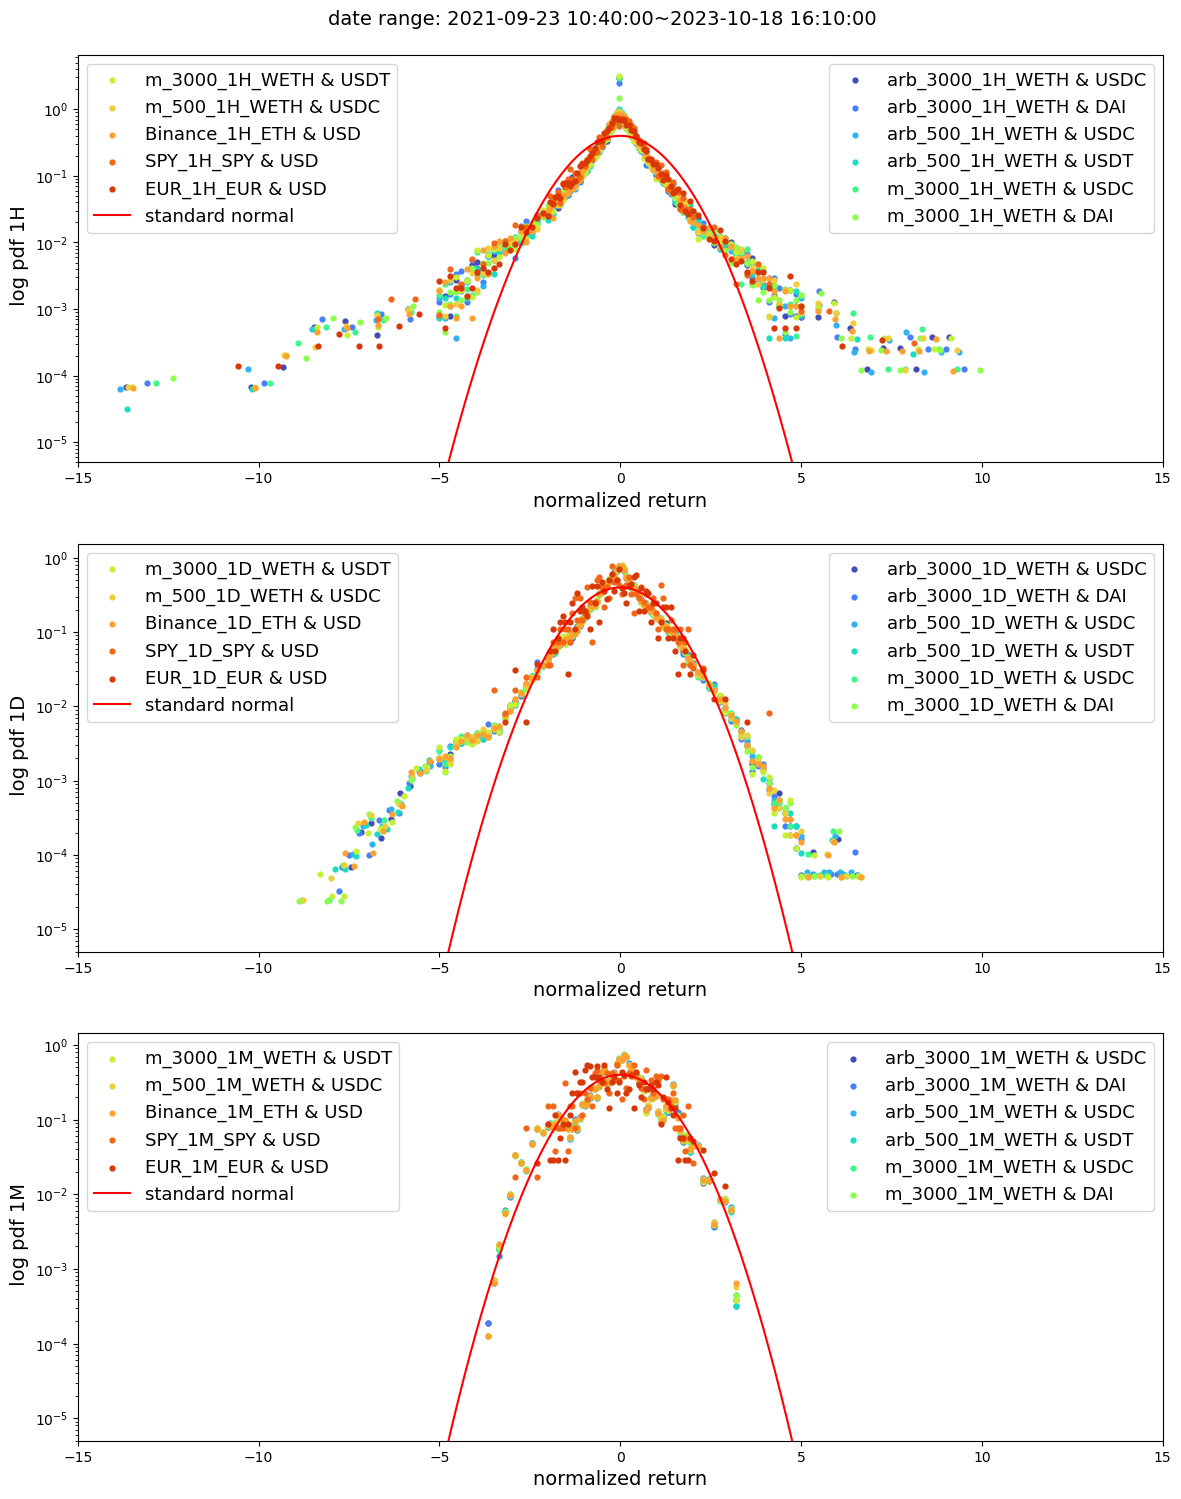

In [31]:
c = hex_colors[::20]
fix , ax = plt.subplots(3,1, figsize=(14,18))
k=0
for df in temp:    
    label = df.label[0]
    if (label =='Binance all') or (label =='SPY all') or (label =='EUR all'):
        continue
    token = df.token[0]
    if (token == 'BTC & USD' ):
        continue
    t = df.dT[0]
    array =df['return'][1:].values
    #remove zeros
    array = array[array != 0]
    prob, bins= plot_pdf(array);
    if t == '1H':
        j=0
        k+=1
    elif t == '1D':
        j=1
    elif t == '1M':
        j=2
    else:
        continue
    ax[j].scatter(bins[:-1], prob,label= f'{label}_{t}_{token}' ,color = c[k],s=12)
#plot standard normal
x = np.linspace(-5,5,10000)
norm=sci.stats.norm.pdf(x,0,1)
for i,t in enumerate(['1H','1D','1M']):
    ax[i].semilogy(x,norm,color='red',label = 'standard normal')
    handles, labels = ax[i].get_legend_handles_labels()
    n = len(handles)
    first_legend = ax[i].legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize = 13)
    ax[i].add_artist(first_legend)
    ax[i].legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2,fontsize = 13)
    
    ax[i].set_xlabel('normalized return',fontsize=14)
    ax[i].set_ylabel(f' log pdf {t}',fontsize=14)
    # ax[i].set_yscale('log')
    ax[i].set_ylim(5*10**(-6),top=None)
    ax[i].set_xlim(-15,15)
plt.figtext(0.5, 0.905, f'date range: {start_time}~{end_time}' , ha='center', va='top', fontsize=14);

### cdf
For cdf, We normalize return arrays(keep zeros) using the usual standard deviation and median, and then compute cdf $F(x)$. After that, we plot

\begin{equation*}
    \begin{cases}
         \log{ 1- F(x)} & \text{if} \;\; x \geq 0
        \quad (\text{denoted by} \; \square)
        \\
        \log{F(-x)} & \text{if} \;\; x < 0
        \quad (\text{denoted by} \;  \blacktriangle)
    \end{cases}
\end{equation*}

We can see more significant asymmetry in left/right tail. Convergence toward standarn Gaussian is also clear. 
One interesting thing is that at 1M scale, EUR has larger values in positive(above normal) than negative part(below normal) unlike the others

#### Pools & CEX & trad fin

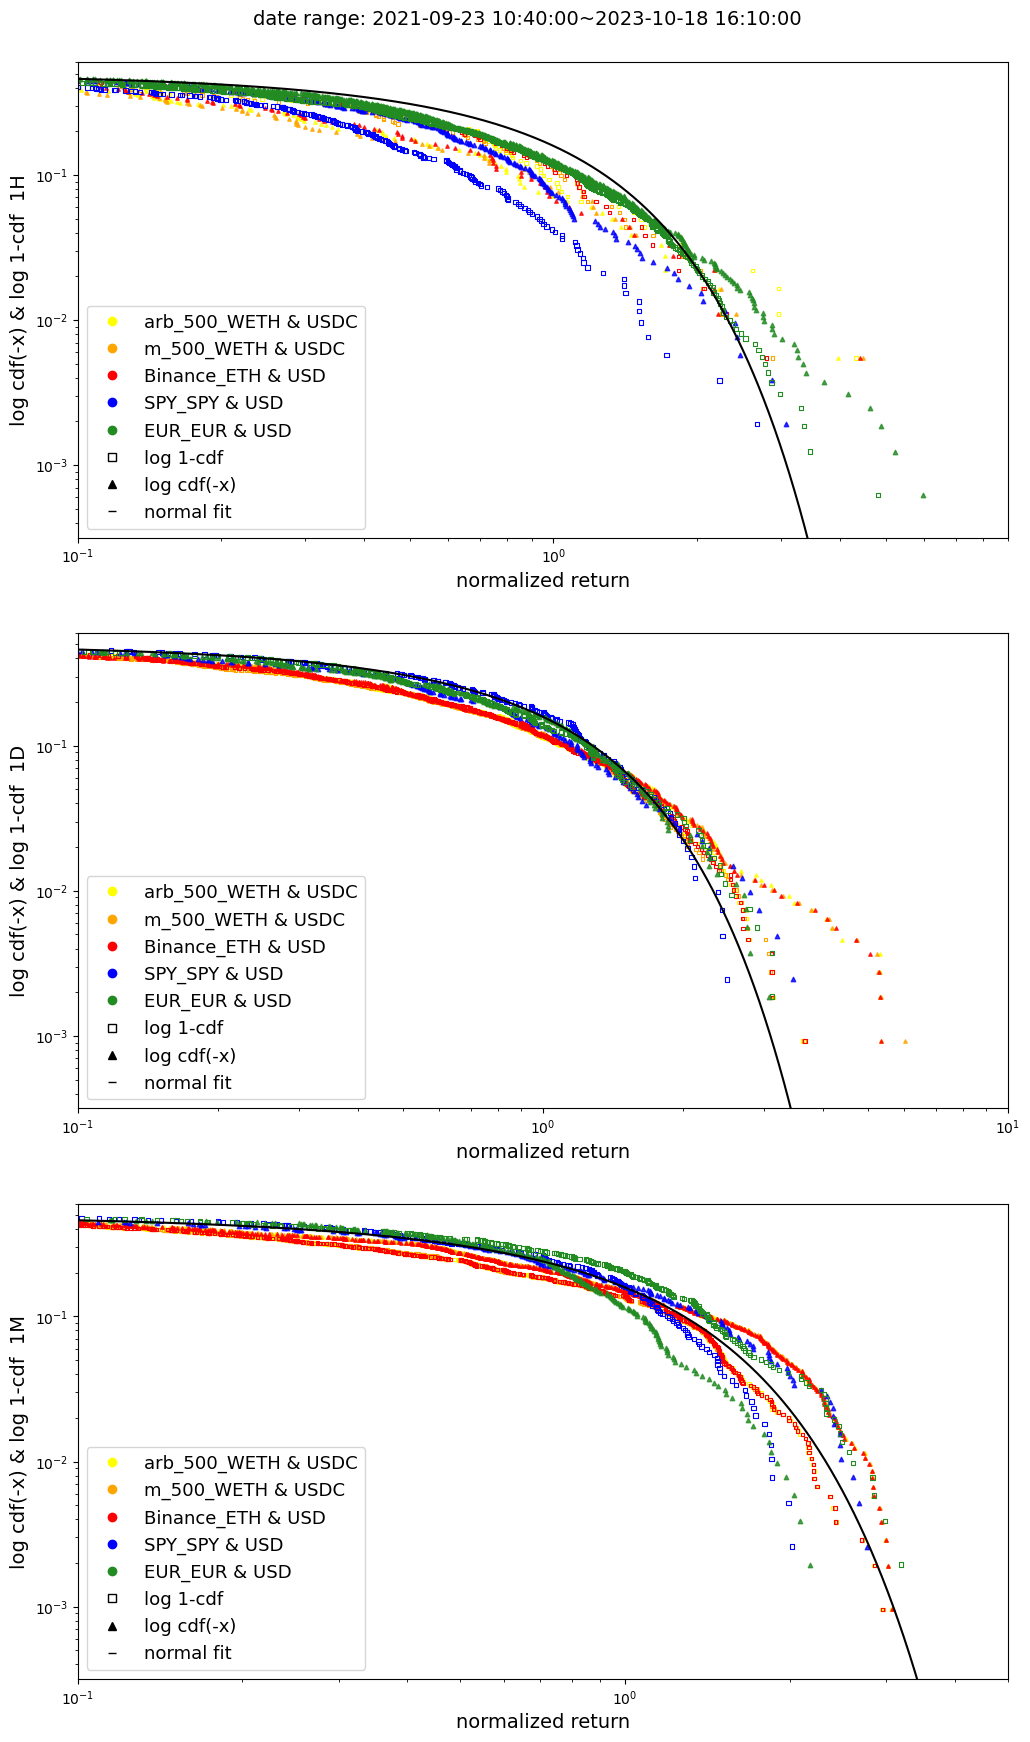

In [131]:
marker_list =['s','^']
time_list = ['1H','1D','1M']
label_dict = { 'arb_500':0, 'm_500':1,'Binance':2,'SPY':3,'EUR':4}
c_cdf= ['yellow','orange','red','blue','forestgreen']
legend_list=[]
label_list= list(label_dict.keys())
fig,ax = plt.subplots(len(time_list),1 ,figsize=(12,7*len(time_list)))
for df in temp:
    if  (df.label[0] not in label_list) or (df.dT[0] not in time_list):
        continue
    k= label_dict[df.label[0]]
    if (k< 2) and (df.token[0] != 'WETH & USDC'):
        continue
    if (k== 2) and (df.token[0] != 'ETH & USD'):
        continue   
    if k >= 3 :
        N=1
    else:
        N=100
    t = df.dT[0]
    label = df.label[0]
    token= df.token[0]

    if  t =='1H':
        i = 0
        if k >=3:
            N=8
        # scale = 0.3/np.sqrt(360*24)
    elif t=='1D':
        i=1
        # scale = 0.3/np.sqrt(250)
    elif t=='1M' :
        i=2
        # scale = 0.3/np.sqrt(12)
        legend_list.append(f'{label}_{token}')
        
    array =df['return'][1:].values
    # array = array[array!= 0]
    array = array - np.median(array)
    std = np.std(array) 
    
    array = (array/std)[::N]
    c = c_cdf[k]
    
    df_plot = cdf_df(array,norm=False)
    df_plot.loc[:,'y']=df_plot.apply( lambda r: np.exp(cdf_modify(r.x,r.y,0)) ,axis=1)
    if label in ['SPY','EUR']:
        s = 10
    else : 
        s=6
    ax[i].scatter(df_plot[df_plot.x >=0]['x'], df_plot[df_plot.x >=0]['y'] , marker= marker_list[0]
                  ,s=s , facecolor ='none', edgecolor = c , linewidth = 0.8 )
    ax[i].scatter(-df_plot[df_plot.x <0]['x'], df_plot[df_plot.x <0]['y'] , c = c
                  , marker = marker_list[1] , s=s , alpha= 0.8 )

        
#legend setting
color_legend = [Line2D([0], [0], color=c_cdf[k], marker='o', linestyle='') for k in range(len(label_dict))]
marker_legend =[Line2D([0], [0], color='k', marker='s',  markerfacecolor ='none',linestyle=''),
                Line2D([0], [0], color='k', marker='^', linestyle=''), 
                Line2D([0], [0], color='k', marker="_", linestyle='')]
#plot std normal cdf
x= np.linspace(0,10,10000)
norm= sci.stats.norm.cdf(x,0,1)
for i,t in enumerate(time_list):
    ax[i].plot(x,1-norm,c='k', label=f'standard normal')
    ax[i].set_xlabel('normalized return',fontsize=14)
    ax[i].set_ylabel(f'log cdf(-x) & log 1-cdf  {t}',fontsize=14)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')

    ax[i].legend(
        color_legend+marker_legend    , legend_list+[ 'log 1-cdf','log cdf(-x)' ]+['normal fit'],
        prop={'size': 13})
    if t== '1H':
        xlim = 9
        ylim = 10**(-3.5)
    elif t=='1D':
        xlim = 10
        ylim = 10**(-3.5)
    elif t == '1M':
        xlim = 5
        ylim = 10**(-3.5)
    ax[i].set_xlim(10**(-1),xlim)
    ax[i].set_ylim(ylim,0.6)
plt.figtext(0.5, 0.905, f'date range: {start_time}~{end_time}' , ha='center', va='top', fontsize=14);

## 2. Autocorrelation(hourly)
For acf of pool data, we compute acf directly. For trad finance data which is not 24/7
, we first collect all possible lag 
values and the returns/ absolute returns pairs corresponding to the given lag. For each
lag $k$, we compute acf by:

\begin{equation}
    \frac{  \frac{1}{\sqrt{N}}\displaystyle
    \sum_{(x_t,x_{t+k}) \in I_k} (x_t - \hat{\mu}_1) (x_{t+k} - \hat{\mu}_2 )}{\hat{\sigma}_1 \hat{\sigma}_2 }
\end{equation}

where $I_k$ is the collection of pairs corresponding to the lag $k$, $N$ is the 
length of $I_k$,   and

$$\hat{\mu}_1 = \frac{1}{N}\displaystyle\sum_{(x_t,x_{t+k}) \in I_k} x_t \; , \; 
\hat{\mu}_2 = \frac{1}{N} 
\displaystyle\sum_{(x_t,x_{t+k}) \in I_k} x_{t+k} \; , \;
\hat{\sigma}_1 = \sqrt{\frac{1}{N}
\displaystyle \sum_{(x_t,x_{t+k}) \in I_k} (x_t - \hat{\mu}_1)^2} \; \text{and} \; \hat{\sigma}_2 = \sqrt{\frac{1}{N} \displaystyle\sum_{(x_t,x_{t+k}) \in I_k} (x_{t+k} - \hat{\mu}_2)^2}$$

We also scale the acf value by multiplying it by square root of the length of data to get a common error bar.


For acf of return, we see that 30bp pools have positive acf value compared with other assets that have higher trading frequency. ETH return on CEX with the whole timeframe exhibits siginificant negative acf value at initial lags as reported. On the other hand, crypto data has siginificant negative acf values at lag = 24hr, other than that, they're more or less bounded inside the error bars.

For acf of abs return, we see acf decays slowly for crypto data as reported, which is called **volatility clustering**: large price variations are
more likely to be followed by large price variations, and such dependency is long range. But for trad finance data, our method for acf doesn't not indicate volatility clustering, instead it exhibits periodic patterns.

2021-09-23 11:00:00
2022-01-21 11:00:00
2023-05-16 11:00:00
2023-09-13 11:00:00
2021-09-23 11:00:00
2022-01-21 11:00:00
2023-01-16 11:00:00
2023-05-16 11:00:00
2023-09-13 11:00:00


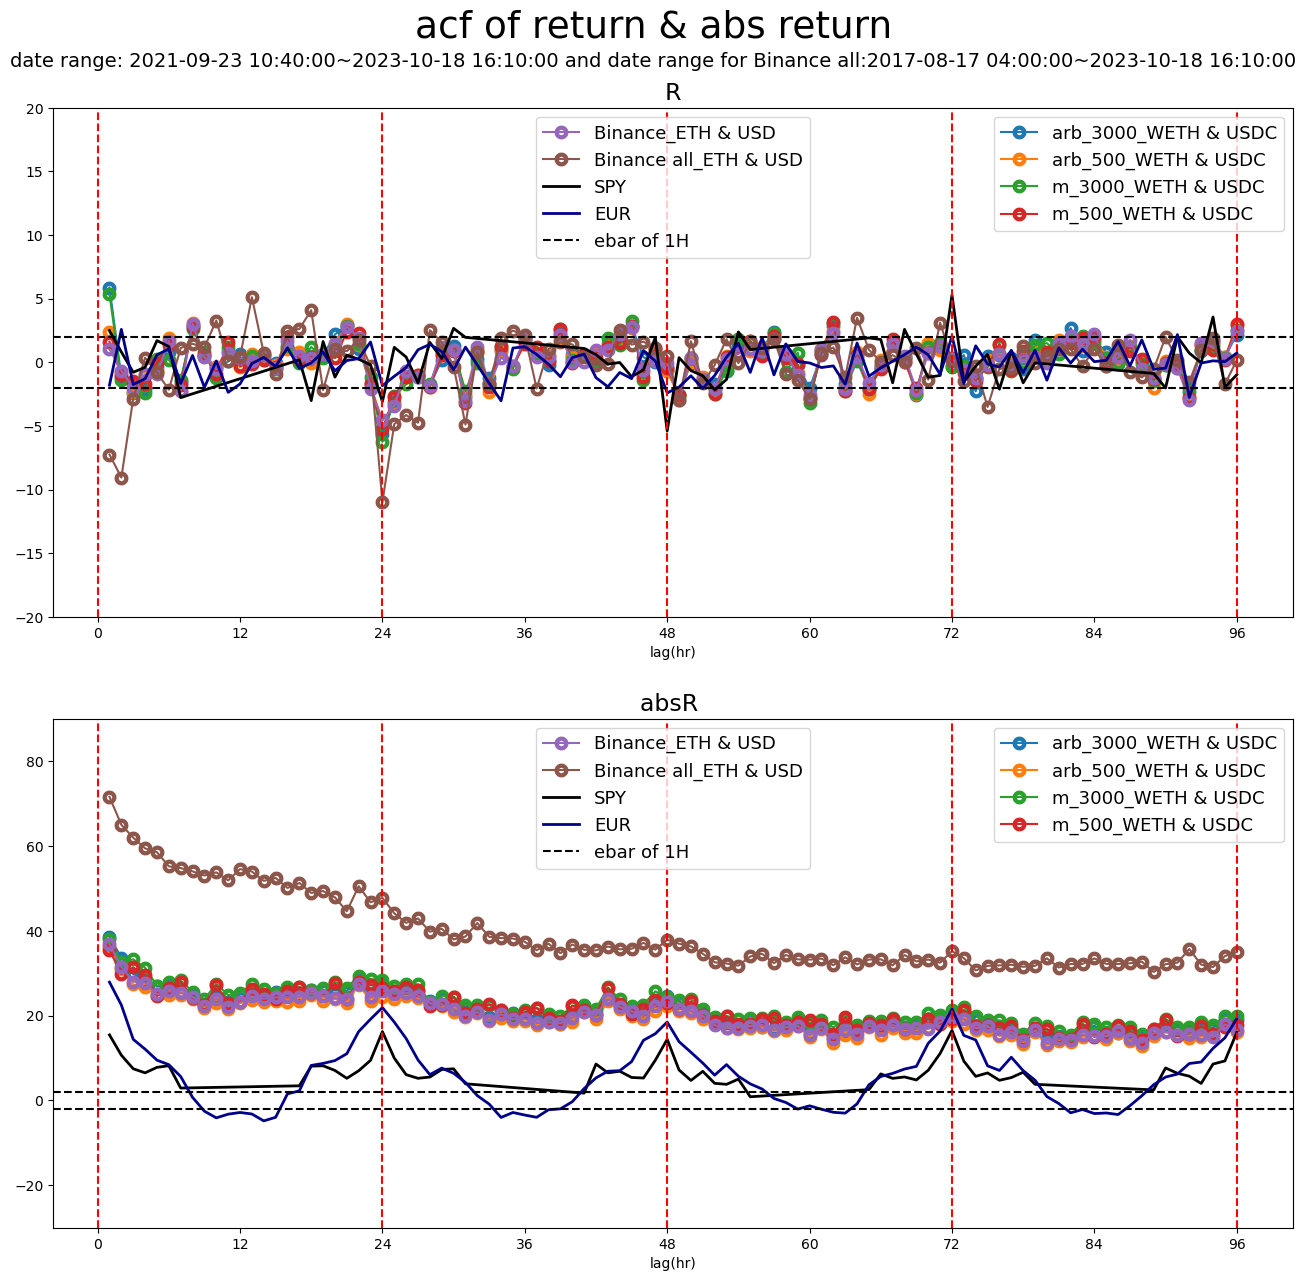

In [54]:
nlags=96
prop_cycle = plt.rcParams['axes.prop_cycle']
c_cycle = prop_cycle.by_key()['color']
start_time_all = '2017-08-17 04:00:00'

acf_dict = plot_acf( ['none','abs'],df_all = df_all[~df_all.label.isin(['SPY','EUR'])] , scale=True)    
df1=plot_acf_2(df_all[df_all.label =='SPY'])
df2=plot_acf_2(df_all[df_all.label =='EUR'])
df_ACF= pd.concat([acf_dict['none'].assign(method='none'),
acf_dict['abs'].assign(method='abs'),df1,df2])

# label_list = ['arb_3000', 'arb_500', 'm_3000', 'm_500', 'Binance','Binance all','SPY','SPY all','EUR','EUR all']
label_list = ['arb_3000', 'arb_500', 'm_3000', 'm_500', 'Binance','Binance all','SPY','EUR']

fig,ax=plt.subplots(2,1,figsize=(16,14))

for l,method in enumerate(['none','abs']):
    df_acf = df_ACF[df_ACF['method']==method].copy()
    for k,lab in enumerate(label_list):
        df1= df_acf[(df_acf.label==lab)&(df_acf.dT== '1H')]
        for token in np.unique(df1.token.values):
            if (token =='WETH & DAI') or (token =='WETH & USDT') or (token =='BTC & USD'):
                continue
            df = df1[df1.token == token]
            if lab in ['SPY','EUR']:
                c = {'SPY': 'k','EUR':'darkblue' }[lab]
                ax[l].plot( df.Lags[1:],df['value'][1:],label=lab
                     ,c = c,lw=2)
            else:
                ax[l].plot( df.Lags[1:],df['value'][1:],label=f'{lab}_{token}',marker='.'
                     ,mfc ='none', c = c_cycle[k],mew=7 )

                
    ax[l].axhline(y= 2,c='k',linestyle='dashed', label=f'ebar of 1H')
    ax[l].axhline(y=-2,c='k',linestyle='dashed')
    #labels setting
    handles, labels = ax[l].get_legend_handles_labels()
    n = len(handles)
    first_legend = ax[l].legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=13)
    ax[l].add_artist(first_legend)
    ax[l].legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ],loc = 9 ,fontsize = 13)
    ax[l].set_xlabel('lag(hr)')
    
    #setting ylim and title text w.r.t sepcific method
    if l ==0:
        ylim_p =20
        ylim_n =-20
        title = 'R'
    else :
        ylim_p = 90
        ylim_n = -30
        title = 'absR '
    ax[l].set_ylim(ylim_n,ylim_p)
    ax[l].set_xticks([0,12,24,36,48,60,72,84,96])

    ax[l].set_title( title, fontsize = 17)
#plot daily vline
for x in [0,24,48,72,96]:
    ax[0].axvline(x=x,c='red',linestyle='dashed')
    ax[1].axvline(x=x,c='red',linestyle='dashed')
    
plt.figtext(0.5, 0.95, f'date range: {start_time}~{end_time} and date range for Binance all:{start_time_all}~{end_time}'
            , ha='center', va='top', fontsize=14)
plt.suptitle('acf of return & abs return', fontsize=27)
plt.subplots_adjust(hspace=0.2, top=0.91)

## 3.Leverage effect(hourly)
It is reported that volatility and return are negative correlated in short time region. Such phenomenon is called 
**leverage effect**. 

Here we quantify this effect by the correlation between return and absolute return $(R \to \lvert R \rvert)$:

$$L(k) \equiv \frac{\mathbb{E}\left[ (\lvert R_{t+k} \rvert -\mu_{\lvert R \rvert}) (R_{t} -  \mu_R)\right]}{\sigma_{\lvert R \rvert} \sigma_R}$$

Our results show that most data exhibits such effect except for BTC from CEX and EUR.

In [56]:
onehr_lsit=[]
for df in df_list:
    if df.dT[0]== '1H':
        print(df.label[0],df.token[0])
        onehr_lsit.append(df)


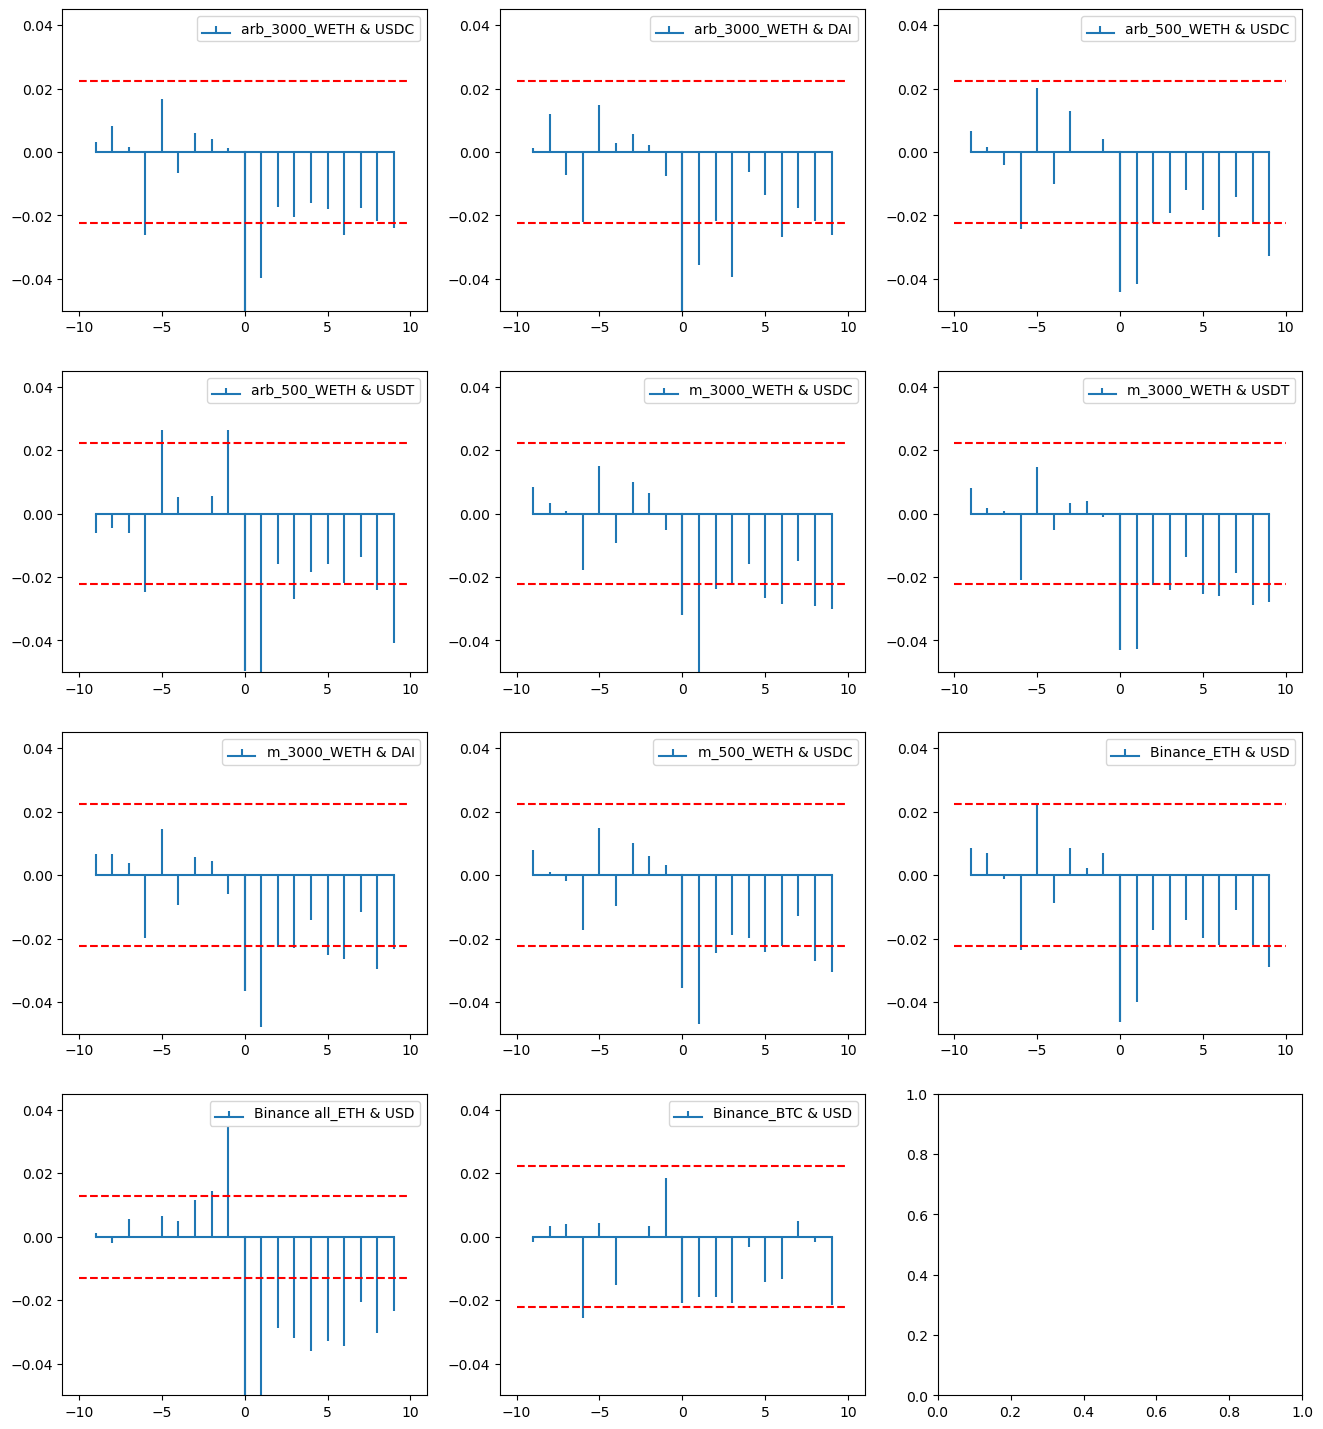

In [63]:
fig,ax = plt.subplots(4,3,figsize=(16,18))
for k,dff in  enumerate(onehr_lsit):
    df= dff.dropna()
    i = int(k/3)
    j = k%3
    lags_array , y_p ,y_n = leverage(df,dT='1H',nlag = 10)
    #plt.plot(lags_array,y_p,label =f'{df.label[0]}_{df.token[0]}')
    ax[i,j].stem(-lags_array,y_n, linefmt='-' , markerfmt='', basefmt='C0-', 
        label =f'{df.label[0]}_{df.token[0]}')
    ax[i,j].stem(lags_array, y_p , linefmt='-' , markerfmt='', basefmt='C0-')
    ax[i,j].hlines(y=3/np.sqrt(df.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax[i,j].hlines(y=-3/np.sqrt(df.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax[i,j].set_ylim(-0.05,0.045)
    ax[i,j].legend()

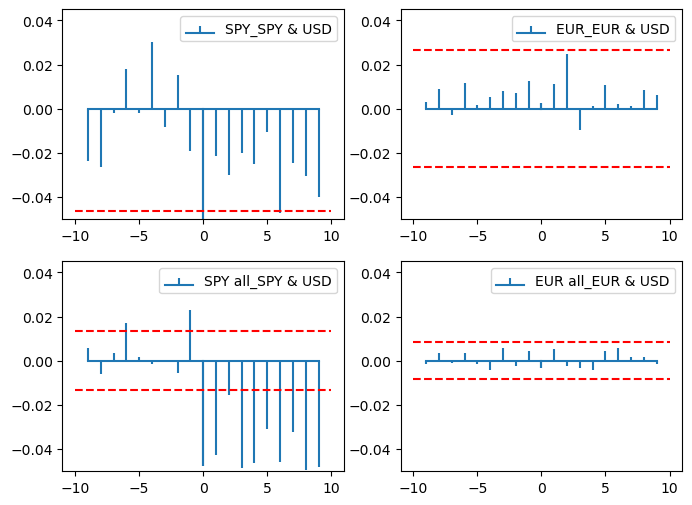

In [64]:
fig,ax = plt.subplots(2,2,figsize=(8,6))
for k,dff in  enumerate(df_list_trad):
    df= dff.dropna()
    i = int(k/2)
    j = k%2
    lags_array , y_p ,y_n = leverage(df,dT='1H',nlag = 10)
    #plt.plot(lags_array,y_p,label =f'{df.label[0]}_{df.token[0]}')
    ax[i,j].stem(-lags_array,y_n, linefmt='-' , markerfmt='', basefmt='C0-', 
        label =f'{df.label[0]}_{df.token[0]}')
    ax[i,j].stem(lags_array, y_p , linefmt='-' , markerfmt='', basefmt='C0-')
    ax[i,j].hlines(y=3/np.sqrt(df.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax[i,j].hlines(y=-3/np.sqrt(df.shape[0]),xmin=-10,xmax=10,color='red',linestyles='dashed')
    ax[i,j].set_ylim(-0.05,0.045)
    ax[i,j].legend()

## 4.Time reversal asymmetry/Zumbach effect
We compare the $k >0$ part and $k<0$ part of the following correlation:

$$
  C(k) \equiv  
   \frac{ \mathbb{E}\left[ ( \lvert R_t \rvert - \mu_{\lvert R \rvert} )
  ( s^{(D)}_{t+k}  - \mu_{s^{(D)}} )\right] }{ \sigma_{\lvert R \rvert} \sigma_{s^{(D)} }}
  $$
  
where $R$ is the daily return and $s^{(D)}$ is the empirical intraday standard deviation.
It is reported that $C(k) \geq C(-k)$. Predicitivity power!

We also compute their cumulative difference:
$$
    \Delta(N) = \sum^N_{k=1} \left[ C(k) - C(-k) \right]
$$
which will be an increasing function if the statement is true.

For our cases, we have:

* most of them are indeed increasing, indicating the asymmetry.

* ETH from CEX with the whole timeframe and EUR data behave weirdly.

Text(0.5, 1.0, 'TRA cumulative difference')

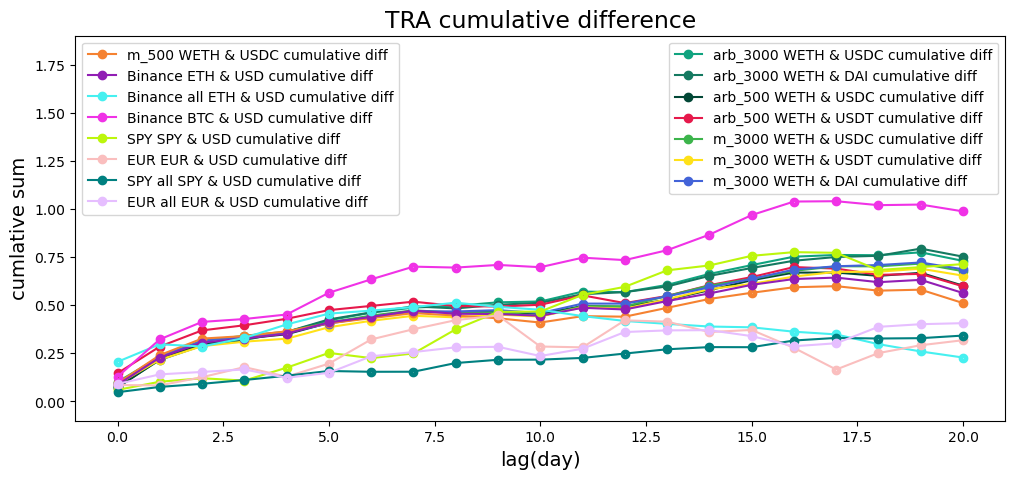

In [133]:
label_token_list =[]
for df in df_list+df_list_trad:
    if df.dT[0] == '1H':
        label_token_list.append( (df.label[0] ,df.token[0]) )

fig,ax = plt.subplots(figsize=(12,5))
for i,(lab,token) in enumerate(label_token_list):
    df = df_all[(df_all.label==lab) & (df_all.token==token)].copy()
    df = df[df.dT=='1H']
    c_mat =time_rev_day(df)
    ax.plot(np.cumsum(c_mat[:,0]-c_mat[:,1]),label=f'{lab} {token} cumulative diff',
               marker='.' ,mfc ='none',mew=4,c=color_list[i])
ax.set_ylim(-0.1,1.9)
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=2)
ax.set_xlabel('lag(day)',fontsize=14)
ax.set_ylabel('cumlative sum',fontsize=14)
plt.title('TRA cumulative difference',fontsize=17)

In [38]:
label_token_list

[('arb_3000', 'WETH & USDC'),
 ('arb_3000', 'WETH & DAI'),
 ('arb_500', 'WETH & USDC'),
 ('arb_500', 'WETH & USDT'),
 ('m_3000', 'WETH & USDC'),
 ('m_3000', 'WETH & USDT'),
 ('m_3000', 'WETH & DAI'),
 ('m_500', 'WETH & USDC'),
 ('Binance', 'ETH & USD'),
 ('Binance all', 'ETH & USD'),
 ('Binance', 'BTC & USD'),
 ('SPY', 'SPY & USD'),
 ('EUR', 'EUR & USD')]

C:\Users\std92\AppData\Local\Temp\ipykernel_3444\1388296095.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_token_list.append( (df.label[0] ,df.token[0]) )


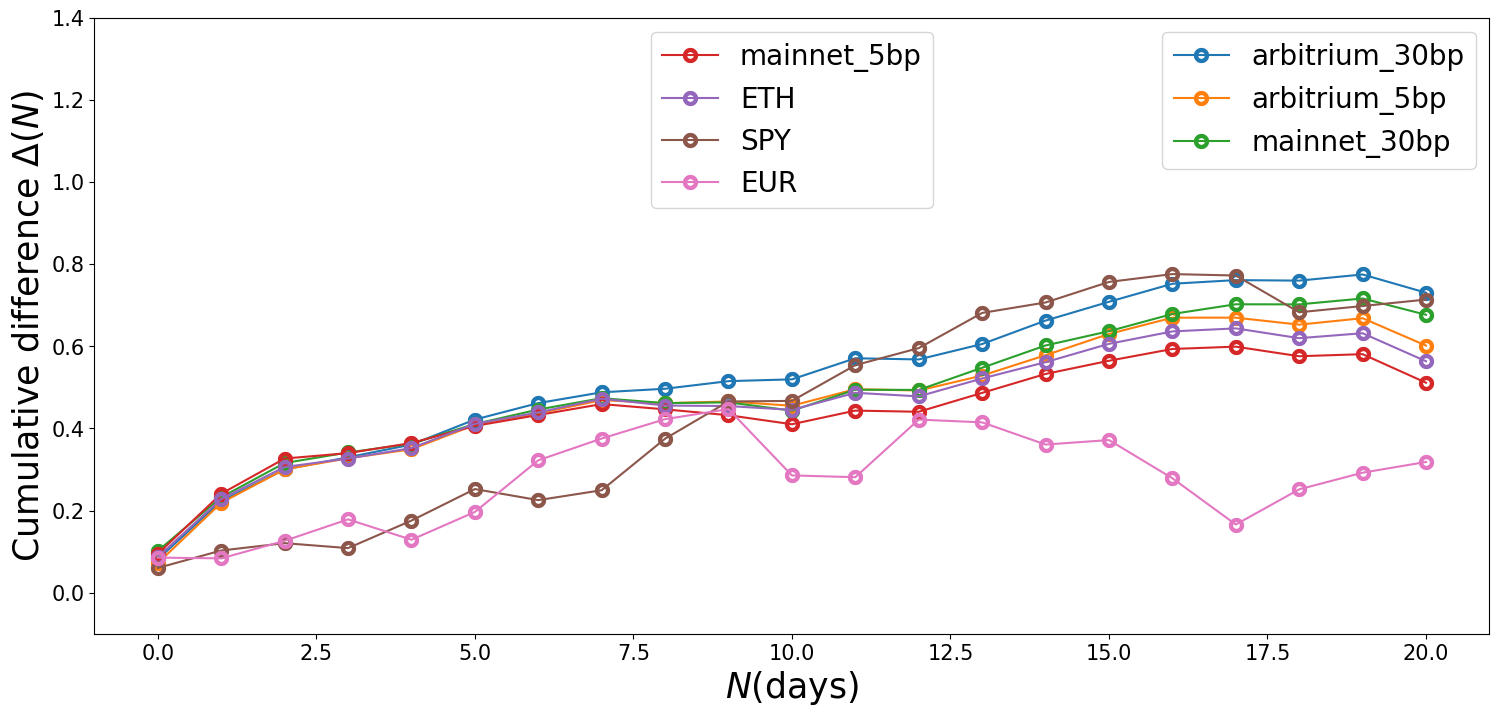

In [33]:
label_token_list =[]
for df in df_list+df_list_trad:
    if df.iloc[0]['label'] in ['SPY all','EUR all','Binance all']:
        continue
    if df.iloc[0]['dT'] == '1H':
        label_token_list.append( (df.iloc[0]['label'] ,df.iloc[0]['token']) )
def _(text):
    if text.startswith(' all'):
        return text[4:]+' all'
    elif text.startswith(' '):
        return text[1:]
    return text
label_dict = {'arb_3000':'arbitrium_30bp', 'arb_500':'arbitrium_5bp', 'm_3000':'mainnet_30bp', 'm_500':'mainnet_5bp'}

fig,ax = plt.subplots(figsize=(18,8))
for i,(lab,token) in enumerate(label_token_list):
    df = df_all[(df_all.label==lab) & (df_all.token==token)].copy()
    df = df[df.dT=='1H']
    if any( s in token for s in ['DAI','USDT','BTC']):
        continue
    if 'Binance' in lab :
        text =_( (lab+token).replace('Binance','').replace(' & USD',''))
    elif lab in label_dict.keys():
        text = label_dict[lab]
    else:
        text = lab
    c_mat =time_rev_day(df)
    ax.plot(np.cumsum(c_mat[:,0]-c_mat[:,1]),label=f'{text}',
               marker='.' ,mfc ='none',mew=8)
ax.set_ylim(-0.1,1.4)
handles, labels = ax.get_legend_handles_labels()
n = len(handles)
first_legend = ax.legend(handles=[ handles[i] for i in range( int(n/2) ) ], loc = 1,fontsize=20)
ax.add_artist(first_legend)
ax.legend(handles=[ handles[i] for i in np.arange(int(n/2),n ) ] ,loc=9,fontsize=20)
ax.set_xlabel(r'$N$(days)',fontsize=25)
ax.set_ylabel(r'Cumulative difference $\Delta(N)$',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=12)


## 5.DEX vs CEX
In Defi, it's well known that there're arbitrage bots(arbitrageurs) that trade between different pools and CEX to earn profit by exploting price difference between these places. We want to identify this from the empirical data. 

If there's only arbitrageurs as traders in the pool, the arbitrageur should trade with the pool until it is pushed to some
target value such that the price difference is not large enough to make a profit provided that there's trading fee. Let $Z$ be the pool price, $S$ be the CEX price and $\gamma$ be the fee constant, it is shown that the optimal target pool price after arbitrage is:

\begin{equation*} 
Z_\text{opt} =
\begin{cases}
\gamma^{-1} S & \text{if } Z > \gamma^{-1} S \\
Z             & \text{if } Z \in  [\gamma S, \gamma^{-1} S]  \\
\gamma S        & \text{if } Z < \gamma S
\end{cases}
\end{equation*}

For 30bp pool, the fee is higher so there's less normal traders(noise traders) and more arbitrageur 
than 5bp pool. The following timeseries plot justifies this. 

In [67]:
df_pool_30 = pd.read_csv('Data/organized data/WETH_USDC_arb_3000/WETH_USDC_arb_3000_1min.csv',index_col='datetime')
df_pool_30.index = pd.to_datetime(df_pool_30.index)
df_pool_5 = pd.read_csv('Data/organized data/WETH_USDC_arb_500/WETH_USDC_arb_500_1min.csv',index_col='datetime')
df_pool_5.index = pd.to_datetime(df_pool_5.index)
df_CEX = pd.read_csv("Data/Binance/ETH/ETH_USD_1min.csv",index_col='datetime')
df_CEX.index = pd.to_datetime(df_CEX.index)
# fee constant
gamma_30 = 1- 0.003
gamma_5 = 1- 0.0005

# align the time frame
pool_CEX_list= [df_pool_30,df_pool_5,df_CEX]
_ =[]
for df in pool_CEX_list:
    _.append( df[(df.index>=start_time) & (df.index<=end_time)] )
    
df_pool_30 =_[0]
df_pool_5 = _[1]
df_CEX = _[2]

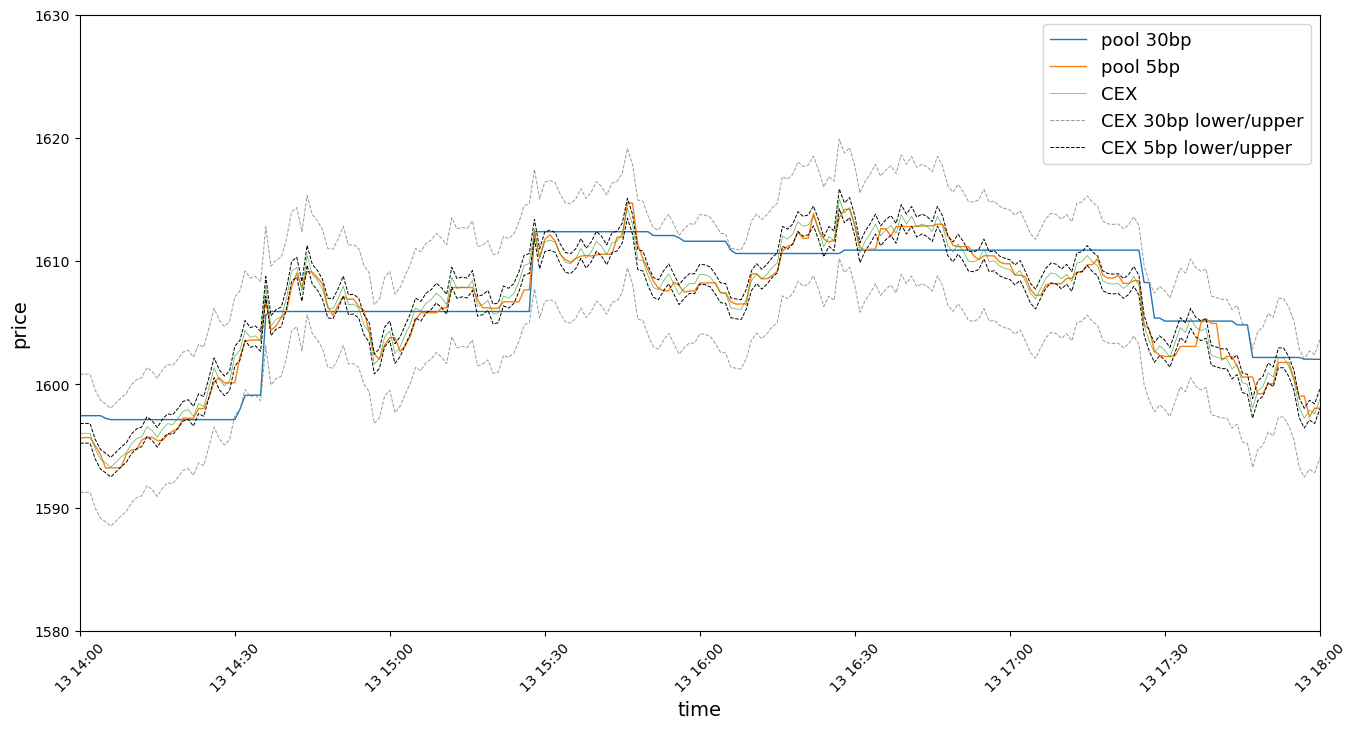

In [68]:
plt.figure(figsize=(16,8))
plt.plot( df_pool_30.index, df_pool_30['close'].values , label="pool 30bp" , linewidth = 1 )
plt.plot( df_pool_5.index, df_pool_5['close'].values , label="pool 5bp" , linewidth = 1 )

plt.plot(df_CEX.index , df_CEX['close'].values,label="CEX",lw=0.5,alpha=0.8)

plt.plot(df_CEX.index , df_CEX['close'].values*gamma_30**(-1),lw=0.7,ls='dashed',c='gray' ,alpha=0.8)
plt.plot(df_CEX.index , df_CEX['close'].values*gamma_30,label="CEX 30bp lower/upper",lw=0.7,ls='dashed',c='gray'  ,alpha=0.8)


plt.plot(df_CEX.index , df_CEX['close'].values*gamma_5**(-1),lw=0.7,ls='dashed',c='k' )
plt.plot(df_CEX.index , df_CEX['close'].values*gamma_5,label="CEX 5bp lower/upper",lw=0.7,ls='dashed',c='k')

plt.xticks(rotation=45)
plt.xlim(datetime(2023,9,13,14,0,0),datetime(2023,9,13,18,0,0))
plt.ylim(1580,1630)
plt.ylabel('price',fontsize=14)
plt.xlabel('time',fontsize=14)
plt.legend(fontsize=13)

We can also try to plot the cross correlation between CEX and pool, which indicates that the pool is 'pushed' by the CEX 

Text(0.5, 1.0, 'date range: 2021-09-23 10:40:00~2023-10-18 16:10:00')

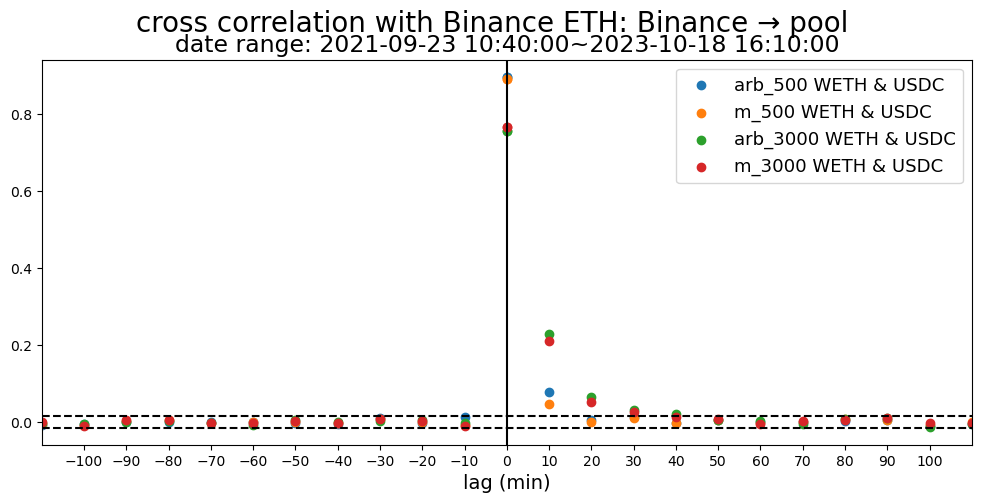

In [70]:
token = 'WETH & USDC'
dT = '10min'
cex_return = df_all[ (df_all.label == 'Binance') &( df_all.token == 'ETH & USD' )& (df_all.dT == dT)]['return'].values

fig,ax = plt.subplots(figsize=(12,5))
for i,lab in enumerate(['arb_500','m_500','arb_3000','m_3000']):
    x_p = cc(lab,token,dT,24)[0]
    x_n = -x_p
    y_p = cc(lab,token,dT,24)[1]
    y_n = cc(lab,token,dT,24)[2]
    #plt.plot(x_p,y_p,color=c_cycle[i],label=f'{lab} {token}',marker='.'
                 #,mfc ='none',mew=3)
    #plt.plot(x_n,y_n,color=c_cycle[i], marker='.'
                 #,mfc ='none',mew=3)
    ax.scatter(10*x_p,y_p,color=c_cycle[i],label=f'{lab} {token}')
    ax.scatter(10*x_n,y_n,color=c_cycle[i])
ax.axvline(x=0,color='k')
ax.axhline(y=2/np.sqrt(18126),color='k',linestyle='dashed')
ax.axhline(y=-2/np.sqrt(18126),color='k',linestyle='dashed')
ax.set_xlabel('lag (min)',fontsize=14)
ax.set_xlim(-110,110)
ax.set_xticks( list(range(-100,110,10)) )
ax.legend(fontsize=13)
plt.suptitle('cross correlation with Binance ETH: Binance → pool',fontsize=20)
plt.title(f'date range: {start_time}~{end_time}',fontsize=17)

In [75]:
from scipy.integrate import quad

# 定義a_mu係數的值
def a_mu_constant(A,mu):
    if mu>1 :
        return A**mu * np.pi / (mu * sci.special.gamma(mu-1) * np.sin(np.pi * mu/2))
    if mu<1 :
        return A**mu * np.pi * mu / ((1-mu) * sci.special.gamma(mu) * np.sin(np.pi * mu/2))

# 定義TLD的傅立葉轉換 abs(x)<< 1/alpha: Levy abs(x)>1/alpha : exponential decay
def inverse_fourier_integrand(z, x, A, mu,alpha):
    return np.exp(-1j * x * z) * np.exp(-a_mu_constant(A,mu) * ((alpha**2 + z**2)**(mu/2) *
                                                                np.cos(mu * np.arctan(abs(z) / alpha)) - alpha**mu) / np.cos(np.pi * mu/2))


# 定義傅立葉反轉換來計算TLD的PDF
def TLD_pdf(x, A, mu, alpha):
  # 進行積分
    TLDpdf=[]
    for t in x:
        result, error = quad(lambda z: inverse_fourier_integrand(z, t, A, mu, alpha).real, -np.inf, np.inf)
        TLDpdf.append(result / (2 * np.pi))
    return TLDpdf

We define the mispricing as the log difference between CEX price and pool price. If there's only arbitrageurs in the pool,
this process should stay inside $[ \ln \gamma , \ln \gamma^{-1}]$. 

In [116]:
ratio = inside_ratio(misP_30, -np.log(gamma_30))
print(f'fraction of time 30bp pool price stays inside no-arb region is {ratio}')

ratio = inside_ratio(misP_5, -np.log(gamma_5))
print(f'fraction of time 50bp pool price stays inside no-arb region is {ratio}')

fraction of time 30bp pool price stays inside no-arb region is 0.8410813117051376
fraction of time 50bp pool price stays inside no-arb region is 0.4863125740783481


Here we plot the empirical pdf of the process, it seems that it can be fit by truncated levy(but the parameter is hard to choose)

In [126]:
x = np.linspace(-0.0075,0.0075,1000)
tld=TLD_pdf(x, A=0.0002, mu=0.85, alpha=3200)

(-100.0, 100.0)

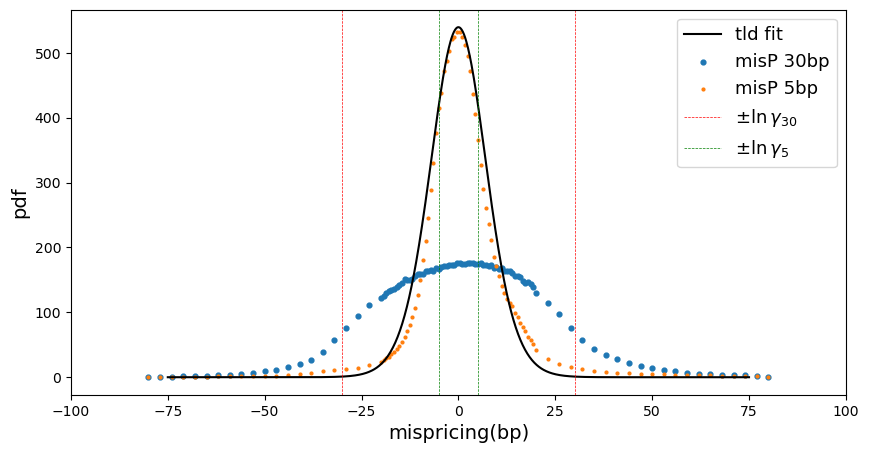

In [127]:
misP_30 =  np.log(df_CEX['close'].values) - np.log(df_pool_30['close'].values)
misP_5 =  np.log(df_CEX['close'].values) - np.log(df_pool_5['close'].values)
prob30,bins30=plot_pdf_misP(misP_30);
prob5,bins5=plot_pdf_misP(misP_5);

plt.figure(figsize=(10,5))

plt.plot(x*10**4,tld,label='tld fit',c='k')
plt.scatter(bins30[:-1]*10**4, prob30, s=12,label='misP 30bp')
plt.scatter(bins5[:-1]*10**4, prob5, s=4,label='misP 5bp')

plt.axvline(x = -np.log(gamma_30)*10**(4) ,lw=0.5,ls='dashed', c= 'red' ,label = r'$\pm \ln \gamma_{30}$')
plt.axvline(x = np.log(gamma_30)*10**(4) , lw=0.5,ls='dashed',c= 'red')
plt.axvline(x = -np.log(gamma_5)*10**(4) ,lw=0.5,ls='dashed',c= 'green' ,label = r'$\pm \ln \gamma_{5}$')
plt.axvline(x = np.log(gamma_5)*10**(4) , lw=0.5,ls='dashed',c= 'green')

plt.xlabel('mispricing(bp)',fontsize=14)
plt.ylabel('pdf',fontsize=14)
plt.legend(fontsize=13)
plt.xlim(-0.01*10**4,0.01*10**4)

We can also choose the effective fee corresponding to smallest $\gamma_{e}$  s.t  $95\%$ of mispircing is in $[\log \gamma_{e}, \log \gamma^{-1}_{e}]$

In [132]:
print(f'the effective fee are 30bp:{1-np.exp(-eff_range(misP_30,0.99))},  5bp:{1-np.exp(-eff_range(misP_5))}' )

the effective fee are 30bp:0.004589894138575246,  5bp:0.003095509032668309


## 6.Reference

* Empirical properties of asset returns:stylized facts and statistical issues, Rama Cont 2000

* The leverage effect in financial markets: retarded volatility and market panic, Jean-Philippe Bouchaud 2008

* The fine-structure of volatility feedback I: multi-scale self-reflexivity, R´emy Chicheportiche 2013